In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [2]:
# Data
data = {
    'Month': pd.date_range(start='2023-05-01', periods=8, freq='MS'),
    'Labor': [2023, 5000, 5000, 5000, 5000, 5000, 2000, 0],
    'Materials': [2000, 2000, 2000, 2000, 1000, 1000, 1000, 0],
    'Revenue Stream #3': [0]*8,
    'Revenue Stream #4': [0]*8,
    'Payroll': [0, 490, 490, 490, 420, 420, 210, 0],
    'Insurance': [2000]*8,
    'Rent': [900]*8,
    'Utilities': [245]*8,
    'Meals': [10]*8,
    'Office expenses': [18]*8,
    'Legal and professional fees': [250]*8,
    'Job expenses': [810, 750, 750, 750, 750, 750, 750, 0],
    'Advertising': [75]*8,
    'Automobile': [273]*8,
    'Maintenance and repairs': [185]*8,
    'Equipment rental': [112]*8,
    'Credit Card Payment': [0]*8,
    'Owners draw': [500]*8,
    'Loan Repayment': [200]*8,
    'Tax savings': [0]*8,
    'Other Savings': [0]*8,
    'Cash Received from Loan': [0]*8,
    'Cash Received from investment': [0]*8
}

df = pd.DataFrame(data)


In [3]:
# Calculations
df['Cash Inflow'] = df[['Labor', 'Materials', 'Revenue Stream #3', 'Revenue Stream #4',
                        'Cash Received from Loan', 'Cash Received from investment']].sum(axis=1)

df['Cash Outflow'] = df[['Payroll', 'Insurance', 'Rent', 'Utilities', 'Meals',
                         'Office expenses', 'Legal and professional fees', 'Job expenses',
                         'Advertising', 'Automobile', 'Maintenance and repairs', 'Equipment rental',
                         'Credit Card Payment', 'Owners draw', 'Loan Repayment',
                         'Tax savings', 'Other Savings']].sum(axis=1)

df['Net Cash Flow'] = df['Cash Inflow'] - df['Cash Outflow']

initial_cash = 10000
df['Opening Balance'] = 0.0
df['Closing Balance'] = 0.0
df.at[0, 'Opening Balance'] = initial_cash
df.at[0, 'Closing Balance'] = initial_cash + df.at[0, 'Net Cash Flow']

for i in range(1, len(df)):
    df.at[i, 'Opening Balance'] = df.at[i-1, 'Closing Balance']
    df.at[i, 'Closing Balance'] = df.at[i, 'Opening Balance'] + df.at[i, 'Net Cash Flow']


In [4]:
# Forecast using ARIMA
model = ARIMA(df['Net Cash Flow'], order=(1,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(steps=6).clip(lower=0)

future_months = pd.date_range(start=df['Month'].iloc[-1] + pd.DateOffset(months=1), periods=6, freq='MS')

forecast_df = pd.DataFrame({
    'Month': future_months,
    'Cash Inflow': [0]*6,
    'Cash Outflow': [0]*6,
    'Net Cash Flow': forecast,
    'Opening Balance': 0.0,
    'Closing Balance': 0.0
})

forecast_df.at[0, 'Opening Balance'] = df.iloc[-1]['Closing Balance']
forecast_df.at[0, 'Closing Balance'] = forecast_df.at[0, 'Opening Balance'] + forecast_df.at[0, 'Net Cash Flow']

for i in range(1, len(forecast_df)):
    forecast_df.at[i, 'Opening Balance'] = forecast_df.at[i-1, 'Closing Balance']
    forecast_df.at[i, 'Closing Balance'] = forecast_df.at[i, 'Opening Balance'] + forecast_df.at[i, 'Net Cash Flow']


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [5]:
# Merge actual + forecast data
final_df = pd.concat([df, forecast_df], ignore_index=True)


In [6]:
# Analysis
final_df['Savings Ratio (%)'] = np.where(final_df['Cash Inflow'] != 0, (final_df['Net Cash Flow'] / final_df['Cash Inflow']) * 100, 0)
final_df['Burn Rate (₹/day)'] = final_df['Cash Outflow'] / 30
final_df['Profit/Loss (%)'] = np.where(final_df['Cash Outflow'] != 0, (final_df['Net Cash Flow'] / final_df['Cash Outflow']) * 100, 0)
final_df['Total Cash Available'] = final_df['Closing Balance']


In [7]:

# Print table
print(final_df[['Month', 'Cash Inflow', 'Cash Outflow', 'Net Cash Flow', 'Opening Balance', 'Closing Balance',
                'Savings Ratio (%)', 'Burn Rate (₹/day)', 'Profit/Loss (%)', 'Total Cash Available']])


        Month  Cash Inflow  Cash Outflow  Net Cash Flow  Opening Balance  \
0  2023-05-01       4023.0        5578.0        -1555.0          10000.0   
1  2023-06-01       7000.0        6008.0          992.0           8445.0   
2  2023-07-01       7000.0        6008.0          992.0           9437.0   
3  2023-08-01       7000.0        6008.0          992.0          10429.0   
4  2023-09-01       6000.0        5938.0           62.0          11421.0   
5  2023-10-01       6000.0        5938.0           62.0          11483.0   
6  2023-11-01       3000.0        5728.0        -2728.0          11545.0   
7  2023-12-01          0.0        4768.0        -4768.0           8817.0   
8  2024-01-01          0.0           0.0            0.0              0.0   
9  2024-02-01          0.0           0.0            0.0              0.0   
10 2024-03-01          0.0           0.0            0.0              0.0   
11 2024-04-01          0.0           0.0            0.0              0.0   
12 2024-05-0

In [8]:
plt.figure(figsize=(14, 8))


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

(array([19478., 19539., 19601., 19662., 19723., 19783., 19844.]),
 [Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05')])

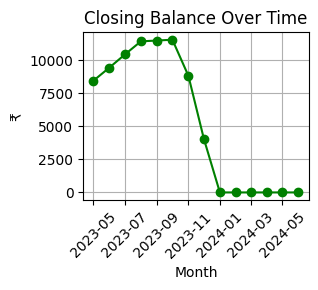

In [9]:
# 1. Line chart – Closing Balance
plt.subplot(2, 2, 1)
plt.plot(final_df['Month'], final_df['Closing Balance'], marker='o', color='green')
plt.title('Closing Balance Over Time')
plt.xlabel('Month')
plt.ylabel('₹')
plt.grid(True)
plt.xticks(rotation=45)


(array([19478., 19539., 19601., 19662., 19723., 19783., 19844.]),
 [Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05')])

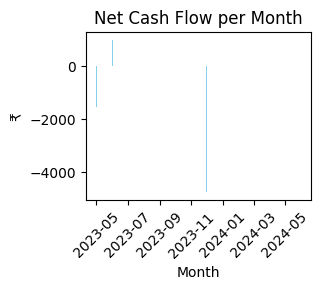

In [10]:
# 2. Bar chart – Net Cash Flow
plt.subplot(2, 2, 2)
plt.bar(final_df['Month'], final_df['Net Cash Flow'], color='skyblue')
plt.title('Net Cash Flow per Month')
plt.xlabel('Month')
plt.ylabel('₹')
plt.xticks(rotation=45)


(array([19478., 19539., 19601., 19662., 19723., 19783., 19844.]),
 [Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05')])

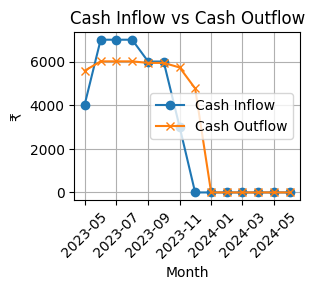

In [11]:
# 3. Line chart – Cash Inflow vs Outflow
plt.subplot(2, 2, 3)
plt.plot(final_df['Month'], final_df['Cash Inflow'], label='Cash Inflow', marker='o')
plt.plot(final_df['Month'], final_df['Cash Outflow'], label='Cash Outflow', marker='x')
plt.title('Cash Inflow vs Cash Outflow')
plt.xlabel('Month')
plt.ylabel('₹')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)


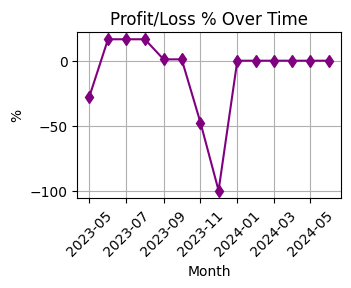

In [13]:
# 4. Line chart – Profit/Loss Percentage (small version)
plt.subplot(2, 2, 4)
plt.plot(final_df['Month'], final_df['Profit/Loss (%)'], marker='d', color='purple')
plt.title('Profit/Loss % Over Time')
plt.xlabel('Month')
plt.ylabel('%')
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


<ipython-input-14-141a655c6a8f>:9: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


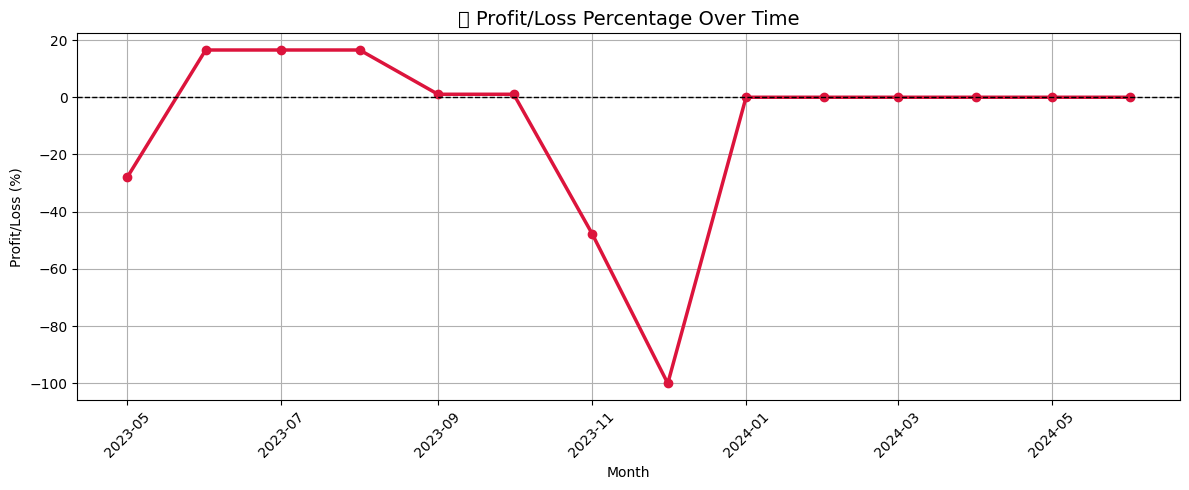

In [14]:
plt.figure(figsize=(12, 5))
plt.plot(final_df['Month'], final_df['Profit/Loss (%)'], color='crimson', linewidth=2.5, marker='o')
plt.title('📉 Profit/Loss Percentage Over Time', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Profit/Loss (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.axhline(0, color='black', linestyle='--', linewidth=1)  # 0% baseline
plt.tight_layout()
plt.show()